In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import copy
import time 
import matplotlib.pyplot as plt
import pickle # Lokales Speichern von Objekten
import keyboard

from GNM_Toolbox.tools.tools import *
from GNM_Toolbox.gnm import *
from GNM_Toolbox.data.dataloader import *

dataset = load_dataset('Cora')

Found dataset on harddrive.


# Some Helping Functions

In [2]:
# Gegeben sei eine target_list (a_0, a_1, a_2, ...)
# und eine out_list ((b_0, x), (b_1, x), (b_2, x), (b_3, x), ...)
# Gesucht wird eine Liste l von Indizes, sodass für i < len(target_list): abs(target_list[i] - out_list[l[i]][0]) minimal ist
def find_each_nearest(target_list, out_list):
    # Each list is expected to be sorted
    i, j = 0, 0
    result = list()
    while True:
        diff_0 = abs(target_list[i] - out_list[j][0])
        diff_1 = abs(target_list[i] - out_list[j+1][0])
        
        if diff_0 >= diff_1:
            j += 1
        elif diff_0 < diff_1:
            result.append(j)
            i += 1
        if i >= len(target_list):
            return result
        if j+1 >= len(out_list):
            while i < len(target_list):
                result.append(j)
                i += 1
            return result
            
def get_best_values_indices(targets, lambdas):
    lambdas.sort(key = lambda x: x[0])
    return find_each_nearest(targets, lambdas)

def h0(x):
    a0, a1, a2, a3 = 13, 4, 15, 15
    return torch.exp(torch.sum(x, dim=1)/a0 - a1) - ((torch.sum(x, dim=1) - a2 ) / a3)
    
def pi0(X, y):
    y0 = F.one_hot(y, 2).type(X.dtype)
    a0, a1, a2 = -torch.log(torch.tensor(35.)), 1, torch.tensor([0, 1.6])
    return torch.sigmoid(a0 + a1 * h0(X) + a2 @ y0.T)

def h1(x):
    a0, a1, a2, a3 = 18, 4, 5, 6
    return torch.exp(torch.sum(x, dim=1)/a0 - a1) - ((torch.sum(x, dim=1) - a2 ) / a3)
    
def pi1(X, y):
    y0 = F.one_hot(y, 2)
    a0, a1, a2 = -torch.log(torch.tensor(25.)), 2., torch.tensor([2, 4])
    return torch.sigmoid(a0 + a1 * h1(X) + a2 @ y0.T)

def create_mask_from_pi(data, pi):
    p = pi(data.x, data.y)
    mask = torch.tensor((np.random.binomial(size = p.shape[0], n = 1, p = p) == 1))        
    return mask.bool()

def split_known_mask_into_val_and_train_mask(known, ratio=0.8):
    val_mask = torch.zeros_like(known) == 1
    train_mask = torch.zeros_like(known) == 1
    for i in range(len(known)):
        if known[i] == True:
            if np.random.binomial(1, ratio) == 1:
                train_mask[i] = True
            else:
                val_mask[i] = True
    return val_mask, train_mask

def calculate_lambda(train_mask, y):
    a = 0 # Anzahl an Klasse 0
    b = 0 # Anzahl an Klasse 1
    for yy in y[train_mask]:
        if yy == 0:
            a += 1
        elif yy == 1:
            b += 1
    return b/a
        
def insert_into_list(l, item, t):
    # l list, i item to insert, target
    def diff(a, b):
        return abs(a-b)
    N = len(l)
    if N == 0:
        l.insert(0, item)
        return
    d = diff(t, item[0])
    d_0 = diff(t, l[0][0])
    if d <= d_0:
        l.insert(0, item)
        return
    for i in range(N-1):
        d_0 = diff(t, l[i][0])
        d_1 = diff(t, l[i+1][0])
        if d_0 <= d and d <= d_1:
            l.insert(i+1, item)
            return
    l.append(item)

def disturb_y(y, probability): # y must have 2 classes
    y_dis = torch.zeros_like(y)
    for i in range(len(y)):
        if np.random.rand(1) < probability:
            y_dis[i] = 0 if np.random.rand(1) > 0.5 else 1
        else:
            y_dis[i] = y[i]
                
    return F.one_hot(y_dis, 2)

# root mean squared error
def RMSE(pi_est, pi_true):
    return torch.sqrt(F.mse_loss(pi_true, pi_est.view(pi_true.shape)))

# mean squared error
def MSE(pi_est, pi_true):
    return F.mse_loss(pi_true, pi_est)

# weighted mean squared error
def WMSE(pi_est, pi_true, weight):
    return torch.mean(weight * (pi_est - pi_true) ** 2)


# mean root error
def MRE(pi_est, pi_true):
    return torch.mean(torch.pow(abs(pi_est.view(pi_true.shape) - pi_true), 0.5))

# berechnet Gewichtungen für weighted mean square error
def calc_inverse_weights(pi_real):
    bins = torch.zeros(len(pi_real)).type(torch.float)
    pi = pi_real.detach().numpy()
    # Count 
    for p in pi_real:
        bins[int(p*100)] += 1
    bins = 1/bins
    bins[bins == (torch.tensor(1.)/0)] = 999999999
    return torch.sqrt(bins)

def eval_pi(pi_true, pi_est, diff=0.01):
    pi_diff = abs(pi_true.view(pi_est.shape)-pi_est)
    pi_binar = [(p < diff) for p in pi_diff]
    return sum(pi_binar)/(1. * pi_true.shape[0])

# Data Setup

In [3]:
# Set up data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.num_classes = 2
# Klassen 0,1,2,4,5,6 werden zu Klasse 1, Klasse 3 wird zu Klasse 0
y = torch.zeros_like(data.y)
y[data.y == 3] = 1
data.y = y

# Verteilung von $\pi$

In [ ]:
bins = np.linspace(0, 1, 50)
pi_true = pi1(data.x, data.y)
plt.hist(pi_true[data.y == 1], bins, alpha=0.6, color='red', edgecolor='black', label='1');
plt.hist(pi_true[data.y == 0], bins, alpha=0.6, color='blue', edgecolor='black', label='0');
plt.legend();
mask = create_mask_from_pi(data, pi1)
print('M1 = {:.3f} \nM2 = {:.3f} \nPerc = {:.3f}'.format(torch.mean(pi_true[mask]), 
                                            torch.mean(pi_true[mask.logical_not()]),
                                            sum(mask)/(1. * len(data.y))))
plt.figure()
plt.hist(pi_true[(data.y == 1) & mask], bins, alpha=0.6, color='red', edgecolor='black', label='1');
plt.hist(pi_true[(data.y == 0) & mask], bins, alpha=0.6, color='blue', edgecolor='black', label='0');

Im folgenden wird überprüft, wie gut der MSE werden kann, wenn man eine Konstante als Schätzer wählt

# Erstelle jeweils 40 Masken

In [4]:
masks1 = list()
for i in range(80):
    mask1 = create_mask_from_pi(data, pi1)
    val_mask1, train_mask1 = split_known_mask_into_val_and_train_mask(mask1)
    masks1.append((None, train_mask1, val_mask1))

# Analysiere $\textit{Model 1}$

## Vorbereitung

In [5]:
choosen_masks = {1: masks1}
pi_true = pi1(data.x, data.y)
weights = calc_inverse_weights(pi_true)
weights

tensor([2.3709e-02, 6.5938e-02, 9.1287e-02,  ..., 3.1623e+04, 3.1623e+04,
        3.1623e+04])

## Analysiere wie gut $L_2$  $\pi$ approximiert

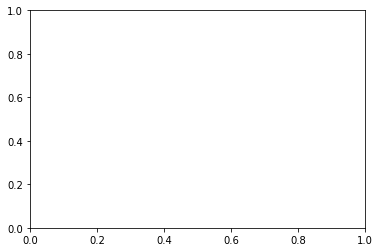

In [11]:
# Eval 
IT_per_mask = 2
NB_masks = len(choosen_masks[1])
M = len(choosen_masks)
t_0 = time.time()
noise_levels = [0, 0.1, 0.2, 0.4, 0.8, 1.1]
all_models = dict()
test = None
fig = plt.figure()
ax = fig.subplots()
# Iteriere über Masken
for i, l in enumerate(choosen_masks):
    sms_models = list() # SM Standard
    smn_models = [list() for _ in range(len(noise_levels))] # change to len(noise_levels)
    
    for j, mask_tupel in enumerate(choosen_masks[l]):
        _, train_mask, val_mask = mask_tupel

        # Trainiere jeweils N Modelle
        for k in range(IT_per_mask):
            print_status(i * NB_masks * IT_per_mask + j * IT_per_mask + k, M * NB_masks * IT_per_mask, t_0)
            for m, noise_level in enumerate(noise_levels):
                y_noise = disturb_y(data.y, noise_level)
                pi_est, loss_list, acc_r = train_modelr3(data.x, data.y, data.num_classes, train_mask, val_mask, y_noise, expectation='other')
                
                #acc_pi = eval_pi(pi_est, pi_true, diff=0.02)
                
                smn_models[m].append(loss_list[-1])
        all_models[l] = (smn_models)
        #pickle_write('l2_analysis-noise-1/run-{}.pkl'.format(i), all_models)
    all_models[l] = (smn_models)
    #pickle_write('l2_analysis-noise-1/run-{}.pkl'.format(i), all_models)
pickle_write('l2_analysis-cora.pkl', all_models)

In [6]:
def alternative_boxplot(data, x_position, x_width, color):
    # data: list of floats
    # x_postition: float
    # x_width: float
    N = len(data)
    mean = np.mean(data)
    #print('{}:{}'.format(sum([1 for d in data if d > mean]), sum([1 for d in data if d < mean])))
    noise = np.random.rand(N)
    x_positions = x_position - x_width/2. + noise * x_width
    plt.plot(x_positions, np.array(data), '.', color = color)

In [ ]:
alternative_boxplot(pi_true.detach().numpy(), 0, 1, 'red')

In [ ]:
ax = plt.figure().subplots()
for i in range(10):
    xn = np.linspace(-2,2)
    yn = xn**i
    plt.clear()
    ax.plot(xn, yn)
    plt.show()
    time.sleep(1)

# Erkenntnis:

Es scheint nötig zu sein, dass die gegebenen Daten tatsächlich eine signifikant höhere Wahrscheinlichkeit haben, gegeben zu sein. 

Zuvor war das Problem, dass der Mittelwert der gegebenen Daten sehr klein war (ca. 0.06) und der Mittelwert der nicht gegeben Daten kaum kleiner (ca. 0.05).

Dieses Problem wurde nun behoben mit Werten (ca. 0.4 und ca. 0.05)

In diesem Experiment wird überprüft, wie gut $L_2$ $\pi$ approximiert und welchen Einfluss Noise darauf hat.

Dazu werden Netze mithilfe von $L_2$ trainiert. Es werden gelegentlich Klassenzugehörigkeiten gewechselt. Der Wert der Noise beschreibt dabei, wie wahrscheinlich es ist, dass die Klassenzugegörigkeit eines Knotens gewechselt wurde.

# ...

Wenn ich train_modelr3 nutze, ergibt jedes zweite Training ein Model mit Genauigkeit gegen 0.

Jedes andere zweite Training hingegen, ergibt Genauigkeiten um die 65%, was schlecht, aber vernünftig erscheint.

Ich überprüfe nun, ob sich das ändert, wenn ich mit train_modelr trainiere.